# Assignment 1: Benchmarking Neural Nets with the XOR Problem

### DS 6050 - School of Data Science - University of Virginia
In this assignment, you will implement your own neural networks to classify non-linear data from the XOR dataset. For deliverables, you must write code in Python/Pytorch and submit **this** Jupyter Notebook file (.ipynb) to earn a total of 80 pts. Note that you must save your Notebook filename under this format: **yourUvaUserId_assignment_1_ann.ipynb**.



In [94]:
# You might want to use the following packages
import numpy as np
import os
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from functools import partial

import warnings
warnings.filterwarnings("ignore")

2.5.1


---
## 1. THE DATASET AND VISUALIZATION

We will use the non-linear toy data called the XOR dataset. You may use the code snippet below to generate the `train / validate / test` sets. Feel free to change the number of samples, and noise level. To keep the ratio between the sets consistent, please do not change the test_size and random_state parameters.



(720, 2)
(200, 2)
(80, 2)


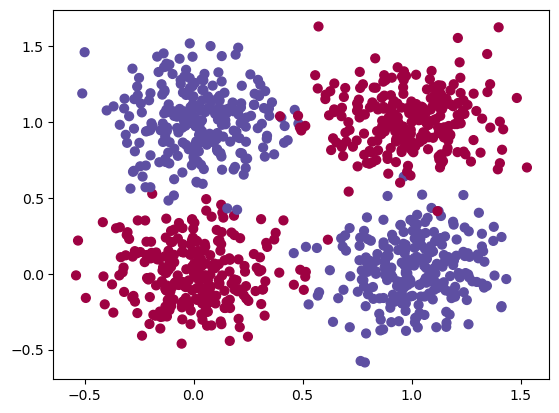

In [95]:
def make_xor(n_points):
    centers = np.array([[0,0],[0,1],[1,0],[1,1]])
    labels = np.array([0,1,1,0])
    data = np.array([]).reshape(-1,3)
    for center, label in zip(centers,labels):
        points = np.random.normal(loc=center,scale=0.2,size=(n_points//4,2))
        points_labels = np.hstack((points,label*np.ones(n_points//4).reshape((-1, 1))))
        data = np.vstack((data,points_labels))
    return (data[:,[0,1]],data[:,2])


X, y = make_xor(1000)
y=y.astype(np.int64)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size= 0.1, random_state=49)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)


---
## 2. TRAIN A SIMPLE ANN FOR CLASSIFICATION TASK

Use the standard libarary of Neural Net on the training data, and then test the classifier on the test data. You will create a simple ANN with 3 layers: an Input Layer, a Hidden Layer and an Output Layer. For each layer, you can specify the number of nodes appropriate for the XOR problem. Also, feel free to tune the network as you see fit. You have to report the accuracy of the network on the validation set.

In [96]:
# Transform data to tensor 
X_train = torch.tensor(X_train, dtype=torch.float)
X_val = torch.tensor(X_val, dtype=torch.float)
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
print(X_val.shape)
print(y_val.shape)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test)


torch.Size([80, 2])
torch.Size([80])


In [97]:
class net(nn.Module):

  def __init__(self):

    super().__init__()
    self.linear1 = nn.Linear(2,10)
    self.linear2 = nn.Linear(10,2)

  # Forward pass 
  def forward(self, x):

    x = torch.tanh(self.linear1(x))
    x = self.linear2(x)
    return x

  # Your code here!
  # TODO: implement a customized module using establised functions from pytorch
  # Loss can be calculated with nn.CrossEntropyLoss()
  # Linear layer could be added to the model with nn.linear()
  # Hyperbolic tangent can be achieved with torch.tanh()
  # Use any optimizer to optimize model parameters
  # An example can be found at: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
  pass

model = net()
print(model)

net(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)


In [98]:
# Hyperparamters:
epochs = 500
learning_rate = 1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # stochastic gradient descent 

# Train model: 
def train(model, X_train, y_train, optimizer):
    model.train()
    pred = model(X_train)
    loss = criterion(pred, y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

# Evaluate model on validation set:
def test(model, X_val, y_val):
    model.eval()
    pred = model(X_val)
    loss = criterion(pred, y_val)
    return loss

for e in range(epochs):
    train(model, X_train, y_train, optimizer)
    loss = test(model, X_val, y_val)
    if (e % 50 == 0):
        y_hat = torch.argmax(model(X_val), axis=1)
        correct_y = (y_hat == y_val).int()
        val_accuracy = sum(correct_y) / y_val.shape[0]
        print(f"Epoch: {e}, Loss: {loss}, Validation Accuracy: {val_accuracy}")
        
# Evaluate model on test set: 
y_hat = torch.argmax(model(X_test), axis=1)
correct_y= (y_hat == y_test).int()
accuracy = sum(correct_y) / y_test.shape[0]
print("\nTest Accuracy: ", accuracy.item())

Epoch: 0, Loss: 0.6998141407966614, Validation Accuracy: 0.5249999761581421
Epoch: 50, Loss: 0.26859861612319946, Validation Accuracy: 0.9624999761581421
Epoch: 100, Loss: 0.09336134046316147, Validation Accuracy: 0.987500011920929
Epoch: 150, Loss: 0.06894224882125854, Validation Accuracy: 0.987500011920929
Epoch: 200, Loss: 0.059803981333971024, Validation Accuracy: 0.987500011920929
Epoch: 250, Loss: 0.055434245616197586, Validation Accuracy: 0.987500011920929
Epoch: 300, Loss: 0.05324249714612961, Validation Accuracy: 0.987500011920929
Epoch: 350, Loss: 0.05222371965646744, Validation Accuracy: 0.987500011920929
Epoch: 400, Loss: 0.05187935382127762, Validation Accuracy: 0.987500011920929
Epoch: 450, Loss: 0.05191739276051521, Validation Accuracy: 0.987500011920929

Test Accuracy:  0.9800000190734863


- - -
## 3. IMPLEMENTING YOUR OWN SIMPLE NEURAL NETWORK

Now that you see how the standard library ANN performs on the XOR dataset, you will attempt to implement your own version of the neural network. To help you, a template has been created including the backpropagation. Essensially, you will get the backward gradients for free. However, please note that the backprop implementation assume usage of tanh activation for the hidden layer and softmax for the output layer. There are some subtasks which you need to implement in order to get the network to work properly.

In [99]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import OneHotEncoder

class MyNeuralNet(BaseEstimator):
    """Your implementation of a simple neural network"""

    def __init__ (self, n0, n1, n2, alpha=0.01):
        """
        @param: n0: Number of nodes in the input layer
        @param: n1: Number of nodes in the hidden layer
        @param: n2: Number of nodes in the output layer
        @param: alpha: The Learning Rate
        """

        # SUBTASK 1: Initialize the parameters to random values.
        np.random.seed(42)
        self.W1 = np.random.normal(0,1,(n0,n1))
        self.b1 = np.zeros((n1, 1))
        self.W2 = np.random.normal(0,1,(n1,n2))
        self.b2 = np.zeros((n2, 1))

        # Configure the learning rate
        self.alpha = alpha
        # One-hot encoder for labels
        self.encoder = OneHotEncoder(sparse=False)

    def forward_pass(self, X):
        """
        Pass the signal forward through the layers.
        @param: X: feature
        @return: A1: saved value of the output of the hidden layer
        @return: A2: activated return value of the output layer.
        """
        # SUBTASK 2: Implement Forward propagation.
        # Note: that you must implement tanh activation for the hiden layer
        # and softmax for the output layer

        Z1 = np.matmul(self.W1.T, X) + self.b1
        A1 = np.tanh(Z1)
        Z2 = np.matmul(self.W2.T, A1) + self.b2
        A2 = F.softmax(torch.tensor(Z2))

        return A1, A2


    def loss(self, X, y):
        """
        Evaluate the total loss on the dataset
        @param: X: features
        @param: y: labels
        @return: L: the loss value
        """
        # SUBTASK 3: Calculate the loss using Cross-Entropy
        # You will need to return the average loss on the data
        # Hint: Use A2 to calculate the loss

        A1, A2 = self.forward_pass(X)

        # Another Hint: First, you may want to convert the lable y into a one-hot vector
        Y = self.one_hot(y)
        L = F.cross_entropy(A2, torch.from_numpy(Y)) 
        avg_L = torch.mean(L) 

        return avg_L

    def backward_pass(self, A1, A2, X, y):
        """
        @param: X: feature
        @param: y: label
        @param: A1: saved value of the output of the hidden layer
        @param: a2: activated return value of the output layer.

        @return: dW1: the loss gradient of W1
        @return: db1: the loss gradient of b1
        @return: dW2: the loss gradient of W2
        @return: db2: the loss gradient of b2
        """

        # You DO NOT CHANGE this function, ...
        # unless you are advanced and want to use different activation function for your forward pass
        # This is an elegant partial derivative of cross entropy with softmax
        # Ref document: https://deepnotes.io/softmax-crossentropy
        # feel free to cross check the calculated gradients with autograd from Pytorch
        # Ref document: https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html
        m   = y.shape[0]
        dZ2 = A2.numpy() - self.one_hot(y) 
        dW2 = np.dot(A1.numpy(), dZ2.T)/m 
        db2 = np.sum(dZ2, axis=1, keepdims=True)/m
        dZ1 = np.multiply(np.dot(self.W2, dZ2), 1-np.power(A1.numpy(), 2)) 
        dW1 = np.dot(X, dZ1.T)/m 
        db1 = np.sum(dZ1, axis=1, keepdims=True)/m 

        return dW1, db1, dW2, db2


    def fit(self, X, y , epochs, X_val, y_val):
        """
        Learns parameters for the neural network and returns the model.

        @param: X: the training feature
        @param: y: the train label
        @param: epochs: Number of passes through the training data for gradient descent
        @param: X_val: the feature of validation set
        @param: y_val: the label of validation set
        """

        # Input checks: X and X_val needs to be in the form of n0 x m
        if (X.shape[0] > X.shape[1]): X = X.T
        if (X_val.shape[0] > X_val.shape[1]): X_val = X_val.T

        # Gradient descent
        for i in range(0, epochs):

            # SUBTASK 4: Compute the forward, backward, and gradient descent parameter update
            # Step 1: Forward pass
            A1, A2 = self.forward_pass(X)

            # Step 2: Backward pass
            dW1, db1, dW2, db2 = self.backward_pass(A1, A2, X, y)

            # Step 3: Gradient Descent
            self.W1 -= self.alpha * dW1
            self.b1 -= self.alpha * db1
            self.W2 -= self.alpha * dW2
            self.b2 -= self.alpha * db2

            # Print the loss and validation accuracy every 10 epochs.
            if i % 10 == 0:
                print("Epoch %i/%i - loss: %f - accuracy: %f - val_loss: %f - val_accuracy: %f"
                      %(i,epochs, self.loss(X, y), self.evaluate(X, y),
                        self.loss(X_val, y_val), self.evaluate(X_val,y_val)))

    def predict(self, X):
        """
        Predict label vector y
        """
        # check X for the form of n0 x m
        if (X.shape[0] > X.shape[1]): X = X.T

        # SUBTASK 5: Implement the prediction process.
        # Hint: It should include a forward pass, and then use the class with higher probability.
        A1, A2 = self.forward_pass(X)
        y_hat = np.argmax(A2.numpy(), axis=0) # get index of highest prob (0 or 1) for each row

        return y_hat


    def evaluate(self, X, y):
        """
        Evaluate the accuracy of the model
        """
        m = y.shape[0]
        y_hat = self.predict(X)
        correct_y = (y_hat == y).int()

        return sum(correct_y)/m


    def one_hot(self, y):
        """
        Utility function: Convert a label vector to one-hot vector
        """
        Y = self.encoder.fit_transform(y.reshape(len(y),1))
        return Y.T # Transpose to get into same shape 1 x m


    def plot_decision_boundary(self, X, y):
        """
        Utility Function: Plot a decision boundary for visualization purpose.
        If you don't fully understand this function don't worry, it just generates the contour plot below.
        """
        # Set min and max values and give it some padding
        x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
        y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
        h = 0.01
        # Generate a grid of points with distance h between them
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        # Predict the function value for the whole gid
        data_grid= np.c_[xx.ravel(), yy.ravel()]
        Z = self.predict(data_grid)
        Z = Z.reshape(xx.shape)

        # Plot the contour and training examples
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
        plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)


---
## 4. REFLECT ON THE COMPARISON BETWEEN YOUR IMPLEMENTATION TO THE STANDARD LIBRARY
Now that you have implemented your own Neural Net class, let's use it! Create at least 3 instances of your Neural Net class, each with a different number of nodes in the hiden layer, tune it with the appropriate learning rate and number of iteration. You will test their performance in the Xor dataset and report the test accuracy metrics for each instance of your neural network.

Based on the test accuracy, compare your models with the standard library version.

Epoch 0/500 - loss: 2368.432519 - accuracy: 0.679167 - val_loss: 175.180867 - val_accuracy: 0.712500
Epoch 10/500 - loss: 2368.407318 - accuracy: 0.693056 - val_loss: 175.157391 - val_accuracy: 0.725000
Epoch 20/500 - loss: 2368.386123 - accuracy: 0.701389 - val_loss: 175.137605 - val_accuracy: 0.750000
Epoch 30/500 - loss: 2368.369304 - accuracy: 0.711111 - val_loss: 175.121932 - val_accuracy: 0.762500
Epoch 40/500 - loss: 2368.356727 - accuracy: 0.713889 - val_loss: 175.110339 - val_accuracy: 0.775000
Epoch 50/500 - loss: 2368.347923 - accuracy: 0.716667 - val_loss: 175.102451 - val_accuracy: 0.775000
Epoch 60/500 - loss: 2368.342277 - accuracy: 0.722222 - val_loss: 175.097722 - val_accuracy: 0.775000
Epoch 70/500 - loss: 2368.339152 - accuracy: 0.727778 - val_loss: 175.095553 - val_accuracy: 0.787500
Epoch 80/500 - loss: 2368.337960 - accuracy: 0.727778 - val_loss: 175.095364 - val_accuracy: 0.787500
Epoch 90/500 - loss: 2368.338190 - accuracy: 0.729167 - val_loss: 175.096635 - val_

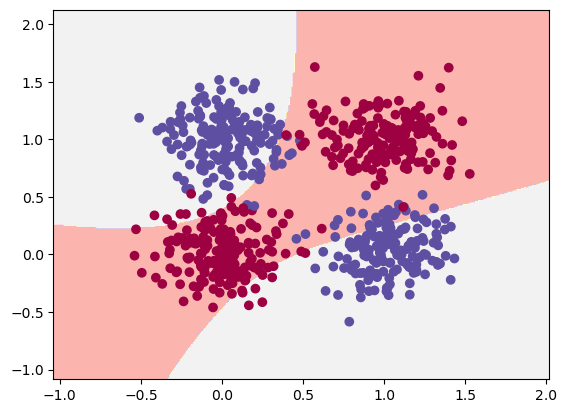

In [104]:
# MODEL 1 here
n0 = 2
n1 = 10
n2 = 2
alpha = 0.01
epochs = 500

# Build a model with 3 layers
myModel1 = MyNeuralNet(n0, n1, n2, alpha)
myModel1.fit(X_train, y_train, epochs, X_val, y_val)
print("Accuracy on the test set is ", myModel1.evaluate(X_test, y_test))

# Plot the decision boundary
myModel1.plot_decision_boundary(X_train, y_train)


Epoch 0/30 - loss: 2368.240919 - accuracy: 0.679167 - val_loss: 174.983785 - val_accuracy: 0.687500
Epoch 10/30 - loss: 2368.502349 - accuracy: 0.698611 - val_loss: 175.252795 - val_accuracy: 0.712500
Epoch 20/30 - loss: 2368.522530 - accuracy: 0.763889 - val_loss: 175.272715 - val_accuracy: 0.712500
Accuracy on the test set is  tensor(0.7900)


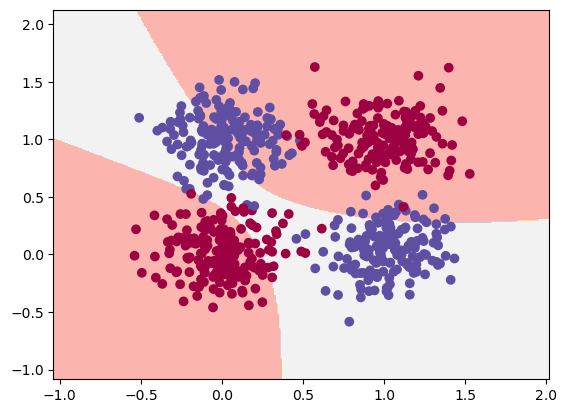

In [108]:
# MODEL 2 here
n0 = 2
n1 = 64
n2 = 2
alpha = 1
epochs = 30

# Build a model with 3 layers
myModel2 = MyNeuralNet(n0, n1, n2, alpha)
myModel2.fit(X_train, y_train, epochs, X_val, y_val)
print("Accuracy on the test set is ", myModel2.evaluate(X_test, y_test))

# Plot the decision boundary
myModel2.plot_decision_boundary(X_train, y_train)

Epoch 0/150 - loss: 2368.174055 - accuracy: 0.640278 - val_loss: 174.892628 - val_accuracy: 0.700000
Epoch 10/150 - loss: 2368.147281 - accuracy: 0.775000 - val_loss: 174.869353 - val_accuracy: 0.787500
Epoch 20/150 - loss: 2368.163871 - accuracy: 0.925000 - val_loss: 174.899751 - val_accuracy: 0.975000
Epoch 30/150 - loss: 2368.240334 - accuracy: 0.918056 - val_loss: 174.999004 - val_accuracy: 0.937500
Epoch 40/150 - loss: 2368.341153 - accuracy: 0.902778 - val_loss: 175.110786 - val_accuracy: 0.925000
Epoch 50/150 - loss: 2368.417300 - accuracy: 0.895833 - val_loss: 175.186025 - val_accuracy: 0.925000
Epoch 60/150 - loss: 2368.442235 - accuracy: 0.902778 - val_loss: 175.208935 - val_accuracy: 0.912500
Epoch 70/150 - loss: 2368.451587 - accuracy: 0.894444 - val_loss: 175.213572 - val_accuracy: 0.925000
Epoch 80/150 - loss: 2368.465018 - accuracy: 0.883333 - val_loss: 175.223769 - val_accuracy: 0.937500
Epoch 90/150 - loss: 2368.475386 - accuracy: 0.880556 - val_loss: 175.233043 - val_

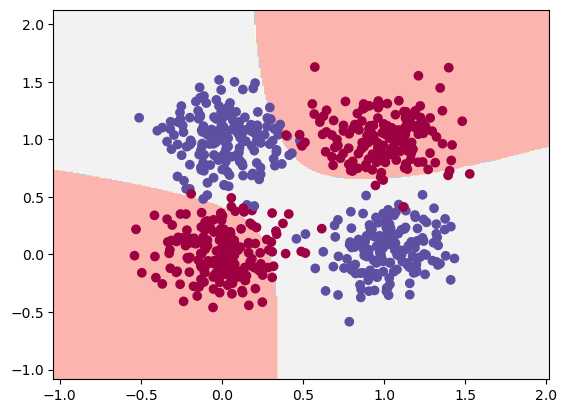

In [109]:
# MODEL 3 here
# MODEL 1 here
n0 = 2
n1 = 100
n2 = 2
alpha = 0.1
epochs = 150

# Build a model with 3 layers
myModel3 = MyNeuralNet(n0, n1, n2, alpha)
myModel3.fit(X_train, y_train, epochs, X_val, y_val)
print("Accuracy on the test set is ", myModel3.evaluate(X_test, y_test))

# Plot the decision boundary
myModel3.plot_decision_boundary(X_train, y_train)

In [110]:
# COMPARISONS OF THESE MODELS WITH THE STANDARD LIBRARY MODEL IN TASK 2
print("Standard Library Model Accuracy: ", accuracy.item())
print("Model 1 Accuracy: ", myModel1.evaluate(X_test, y_test).item())
print("Model 1 Accuracy: ", myModel2.evaluate(X_test, y_test).item())
print("Model 1 Accuracy: ", myModel3.evaluate(X_test, y_test).item())

Standard Library Model Accuracy:  0.9800000190734863
Model 1 Accuracy:  0.9100000262260437
Model 1 Accuracy:  0.7900000214576721
Model 1 Accuracy:  0.949999988079071


## Reflection
Write at least a paragraph answering these prompts: How did your own network perform? Is there any major differences between the implementations? Finally, reflecting on your experience implementing a learning algorithm for this assignment (Was it hard/easy/fun?, From which part did you learn the most?)!

Between the standard library model and my own implementation, the standard library model performed better - at least under my chosen hyperparameters. Overall, the model I wrote in part 3 performed decently given a variety of choices for the number of hidden nodes, learning rate, and epochs, but there is still room for improvement. My most successful model (of part 3) was choosing 100 hidden nodes, a learning rate of 0.1, and running the model for 150 epochs. The main differences I noticed between the standard library and my full implementation were the use of tensor versus numpy functions, and the thouroughness required to calculate and apply gradient descent in the backward pass. Writing a complete class for a neural network was a little harder than I expected, mainly because I was unfamiliar with pytorch. Even now, I am still a little confused on how I can increase my accuracy more - are there mistakes in my implementation or do I need to try other hyperparameter combinations? 

---
# Get Help?
In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lecture slides on Module 2.
 * Post a question in Piazza.
 * Talk to the TA, they are available and there to help you during office hour.
 * Come talk to me or email me <vga8uf@virginia.edu> with subject starting "DS 6050 Assignment 1:...".

Part of the codes used in this assignment is modified from Konstantinos Kitsios under the 3-Clause BSD License. Best of luck and have fun!